# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [ ]:
# Importar las bibliotecas necesarias
import cv2
import os
import numpy as np
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report

In [ ]:
np.random.seed(202)

In [ ]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [ ]:
# Descomprimimos el archivo en tmp para visualizar
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

In [ ]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [ ]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [ ]:
# # Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# # los de los ficheros donde hayas descargado los datos.
# DATASET_TRAIN_PATH_COLAB = "datasets/simpsons"
# DATASET_TEST_PATH_COLAB = "datasets/simpsons_testset"

# X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
# X_test, y_test = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "datasets/simpsons"
DATASET_TEST_PATH_COLAB = "datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_test, y_test = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [ ]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

abraham_grampa_simpson


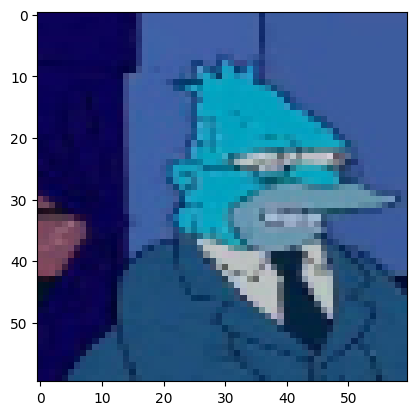

In [ ]:
plt.imshow(X_test[2]) # recordad que siempre es preferible trabajar en blanco y negro
print(MAP_CHARACTERS[y_test[2]])

## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas:
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

In [ ]:
# TENSORFLOW GPU SUPPORT
# ======================
if tf.test.gpu_device_name():
    print("GPU support enabled.")
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU support disabled.")

GPU support enabled.
Default GPU Device: /device:GPU:0


2024-05-30 17:24:13.180635: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-05-30 17:24:13.180671: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-05-30 17:24:13.180680: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-05-30 17:24:13.180708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-30 17:24:13.180728: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-05-30 17:24:13.185567: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been bui

In [ ]:
# TENSORFLOW TPU SUPPORT
# ======================
HAS_TPU_SUPPORT=0
if 'COLAB_TPU_ADDR' not in os.environ:
  print('TPU support disabled.')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU support enabled.')
  HAS_TPU_SUPPORT=1
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()

  print('TPU devices:')
  pprint.pprint(devices)

TPU support disabled.


In [ ]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

## 1. Análisis de datos y preparación

El conjunto de datos, originalmente, viene preparado en:
- Datos de entrenamiento.
- Datos de test.

Sin embargo, nos faltaría un conjunto de datos útil: el de validación.

In [ ]:
# De los datos de entrenamiento sacamos un 20% de datos para validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=202)

Tenemos el siguiente conjunto de datos:
- Entrenamiento: X_train, y_train
- Test: X_test, y_test
- Validación: X_val, y_val

In [ ]:
# Variables con numero de elementos
X_train_num_elem = X_train.shape[0]
X_test_num_elem = X_test.shape[0]
X_val_num_elem = X_val.shape[0]
print("Training shape:", X_train_num_elem,
      "\nTest shape:", X_test_num_elem,
      "\nTest shape:", X_val_num_elem)

Training shape: 15193 
Test shape: 890 
Test shape: 3799


In [ ]:
# Dimensiones
img_rows = IMG_SIZE
img_cols = IMG_SIZE
img_channels = X.shape[3]
print("Cada imagen tiene dimensión", img_rows,
      "x", img_cols,
      "\nY tiene", img_channels, "capas (una para cada componente del color).")

Cada imagen tiene dimensión 60 x 60 
Y tiene 3 capas (una para cada componente del color).


In [ ]:
# Número de categorías
num_categ = len(MAP_CHARACTERS)
print("Hay", num_categ, "categorías, una para cada personaje.")

Hay 18 categorías, una para cada personaje.


In [ ]:
# Comprobamos que efectivamente los resultados son los esperados
print("Número de imágenes de anterior training : " + str(X.shape[0]))
print("Número de imágenes de training (80% de anterior train) : " + str(X_train_num_elem))
print("Número de imágenes de validación (20% de anterior train) : " + str(X_val_num_elem))
print("Número de imágenes de test : " + str(X_test_num_elem))
print("====")
print("Número de resultados de anterior training : " + str(y.shape[0]))
print("Número de resultados de training (80% de anterior train) : " + str(y_train.shape[0]))
print("Número de resultadoss de validación (20% de anterior train) : " + str(y_val.shape[0]))
print("Número de resultados de test : " + str(y_test.shape[0]))
print("====")
print("Dimensiones de training : " + str(X_train.shape))
print("Dimensiones de validation : " + str(X_val.shape))
print("Dimensiones de tests : " + str(X_test.shape))
print("====")
print("Canales de color para las imagenes : "+ str(img_channels))
print("Resolución imágenes de anterior training : " + str(X.shape[1]) + "x" + str(X.shape[2]))
print("Resolución imágenes de training (80% de anterior train) : " + str(X_train.shape[1]) + "x" + str(X_train.shape[2]))
print("Resolución imágenes de validación (20% de anterior train) : " + str(X_val.shape[1]) + "x" + str(X_val.shape[2]))
print("Resolución imágenes de test : " + str(X_test.shape[1]) + "x" + str(X_test.shape[2]))

Número de imágenes de anterior training : 18992
Número de imágenes de training (80% de anterior train) : 15193
Número de imágenes de validación (20% de anterior train) : 3799
Número de imágenes de test : 890
====
Número de resultados de anterior training : 18992
Número de resultados de training (80% de anterior train) : 15193
Número de resultadoss de validación (20% de anterior train) : 3799
Número de resultados de test : 890
====
Dimensiones de training : (15193, 60, 60, 3)
Dimensiones de validation : (3799, 60, 60, 3)
Dimensiones de tests : (890, 60, 60, 3)
====
Canales de color para las imagenes : 3
Resolución imágenes de anterior training : 60x60
Resolución imágenes de training (80% de anterior train) : 60x60
Resolución imágenes de validación (20% de anterior train) : 60x60
Resolución imágenes de test : 60x60


In [ ]:
# Comprobamos el formato de cada muestra...
if keras.backend.image_data_format() == "channels_first":
  # ...si los canales van primero (channels, rows, cols):
  X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
  X_val = X_val.reshape(X_val.shape[0], img_channels, img_rows, img_cols)
  X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)
  input_shape = (img_channels, img_rows, img_cols)
  print("El input va ordenado de la siguiente manera: canales, filas, columnas")
else:
  # ...sino, si los canales van último (rows, cols, channels):
  X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)
  X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, img_channels)
  X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)
  input_shape = (img_rows, img_cols, img_channels)
  print("El input va ordenado de la siguiente manera: filas, columnas, canales")

El input va ordenado de la siguiente manera: filas, columnas, canales


## 2. Normalización de datos

Como hicimos en la primera práctica, tenemos que normalizar los datos

In [ ]:
# Normalizamos y convertimos a float32, de tal manera que seamos capaces de tener valores entre 0 y 1
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")
X_test = X_test.astype("float32")

# Con esto obtenemos valores entre el rango 0...1
X_train /= 255
X_val /= 255
X_test /= 255

# Con esto conseguimos trabajar con categorías en las y (las etiquetas)
y_train = keras.utils.to_categorical(y_train, num_categ)
y_val = keras.utils.to_categorical(y_val, num_categ)
y_test = keras.utils.to_categorical(y_test, num_categ)

Asi, ya tendríamos preparados todos los conjuntos de datos para poner a definir los modelos con los que vamos a trabajar.

## 3. Entrenamiento


Primer modelo, con fully connected

In [ ]:
# Definimos aquí más imports para no tener que ir más arriba en el notebook
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, AveragePooling2D
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, RMSprop
from keras.callbacks import EarlyStopping

Antes de comenzar con modelos CNN, probamos con un fully connected como en la práctica 1

In [ ]:
model_emperor = keras.models.Sequential()
model_emperor.add(keras.layers.Flatten(input_shape=input_shape))
#Inicio con una capa con más neuronas y después añado capas con menor número de neuronas.
# Generalizar más al principio y afinar detalles después.
model_emperor.add(keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#Añadir capas con Dropout bajo al inicio y mayor Dropout en capa más profunda.
model_emperor.add(Dropout(0.1))
#Probando a añadir capas de BatchNormalization, pero en las pruebas tienen el efecto de "estancar" el modelo antes.
model_emperor.add(BatchNormalization())
model_emperor.add(keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_emperor.add(Dropout(0.2))
model_emperor.add(keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_emperor.add(keras.layers.Dense(num_categ, activation="softmax"))

#El mejor resultado obtenido ha sido con un learning_rate de 0.0001 después de múltiples pruebas.
model_emperor.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_fc = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

#50 epochs con earlystopping. Batch 128 parece conseguir mejor resultado que 32 o 64.
history = model_emperor.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping_fc])

Epoch 1/50


/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.2103 - loss: 3.2442 - val_accuracy: 0.1742 - val_loss: 4.1297
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.3037 - loss: 2.6379 - val_accuracy: 0.2258 - val_loss: 3.0502
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.3242 - loss: 2.5051 - val_accuracy: 0.2326 - val_loss: 2.8183
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.3254 - loss: 2.4682 - val_accuracy: 0.2876 - val_loss: 2.7005
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.3280 - loss: 2.4183 - val_accuracy: 0.2000 - val_loss: 2.7788
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.3293 - loss: 2.4080 - val_accuracy: 0.2494 - val_loss: 2.8645
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.3420 - loss: 2.3133 - val_accuracy: 0.2787 - val_loss: 2.5636
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.3519 - loss: 2.2938 - val_accuracy: 0

Los mejores resultados son con un learning rate bajo y tarda mucho en converger.

Después de 35 epochs apenas se llega a un 37% de accuracy en training.

#### **3.1. M1** Primer modelo de prueba:

| Nombre modelo | Cant. capas | Func. act. | Optimizador | Caracts. extra |
| ------------- | ----------- | ---------- | ----------- | -------------- |
|       M1      |      2 Conv (AvgPooling) + 2 Dense      |    Relu    |   Adagrad   |                   |

En este primer modelo, introducimos:

- 2 capas convolucionales `Conv2D`:
    - La primera con 32 filtros de convolución, tamaño de kernel de 3x3 y función de activación relu. Con input_shape indicamos la forma de la entrada de la red.
    - La segunda con 64 filtros de convolución, el resto igual que la anterior capa.  
- 1 capa de pooling `MaxPooling2D` que reduce la dimensionalidad de las características. Con `max`, se queda con el valor máximo en una ventana de 2x2-
- 1 capa `Dropout` para reducir el sobreajuste con probabilidad de desactivación del 25%. Se evita el sobreajuste desactivando una parte de las neuronas durante el entrenamiento.
- 1 capa `Flatten` que transforma la salida de las capas convolucionales en un vector unidimensional.
- Capas convolucionales posteriores:
    - Capa densa de 128 neuronas y función de activación relu.
    - 1 capa `Dropout` con una probabilidad de desactivación de neuronas del 50%.
    - 1 capa densa softmax que nos devuelve la probabilidad de cada categoría multiclase.  

In [ ]:
# Definimos aquí más imports para no tener que ir más arriba en el notebook
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, AveragePooling2D
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, RMSprop

In [ ]:
#Modelo CNN con 2 capas convolucionales y 2 capas densas
m1 = Sequential()
m1.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="m1_conv2d_1"))
m1.add(Conv2D(64, kernel_size=(3, 3), activation="relu", name="m1_conv2d_2"))
m1.add(MaxPooling2D(pool_size=(2, 2), name="m1_maxpool2d_1"))
m1.add(Dropout(0.25, name="m1_dropout_1"))
m1.add(Flatten(name="m1_flatten"))
m1.add(Dense(128, activation="relu", name="m1_dense_1"))
m1.add(Dropout(0.5, name="m1_dropout_2"))
m1.add(Dense(num_categ, activation="softmax", name="m1_softmax"))

m1.summary()

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-30 10:00:37.796474: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-30 10:00:37.796492: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ m1_conv2d_1 (Conv2D)            │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_conv2d_2 (Conv2D)            │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_maxpool2d_1 (MaxPooling2D)   │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_dropout_1 (Dropout)          │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_flatten (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_dense_1 (Dense)              │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_dropout_2 (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m1_softmax (Dense)              │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,444,370 (24.58 MB)

 Trainable params: 6,444,370 (24.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Optimizador Adagrad
"""
  Hyperparams:
   - Learning rate (learning_rate): 0.05
"""
m1_opt = Adagrad(learning_rate=0.05) #Comenzamos con Adagrad

m1.compile(
    loss="categorical_crossentropy",
    optimizer=m1_opt,
    metrics=["accuracy"]
)

In [ ]:
# Entrenamiento
m1_batch_size = 128
m1_epochs = 40 # Aumentamos el número de epochs después de las pruebas iniciales, pues parece que el modelo no ha convergido

m1_hist = m1.fit(X_train, y_train,
  batch_size=m1_batch_size,
  epochs=m1_epochs,
  verbose=True,
  validation_data=(X_val, y_val)
)

Epoch 1/40


2024-05-30 10:01:14.880367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.1530 - loss: 2.7129 - val_accuracy: 0.3393 - val_loss: 2.2580
Epoch 2/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.3190 - loss: 2.2383 - val_accuracy: 0.4191 - val_loss: 1.9408
Epoch 3/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.4395 - loss: 1.8869 - val_accuracy: 0.5525 - val_loss: 1.5600
Epoch 4/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5279 - loss: 1.5721 - val_accuracy: 0.5759 - val_loss: 1.4619
Epoch 5/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5818 - loss: 1.3856 - val_accuracy: 0.6031 - val_loss: 1.3495
Epoch 6/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6272 - loss: 1.2252 - val_accuracy: 0.6804 - val_loss: 1.1345
Epoch 7/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6708 - loss: 1.0765 - val_accuracy: 0.6965 - val_loss: 1.0471
Epoch 8/40
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7104 - loss: 0.9445 - val_accuracy: 0.730

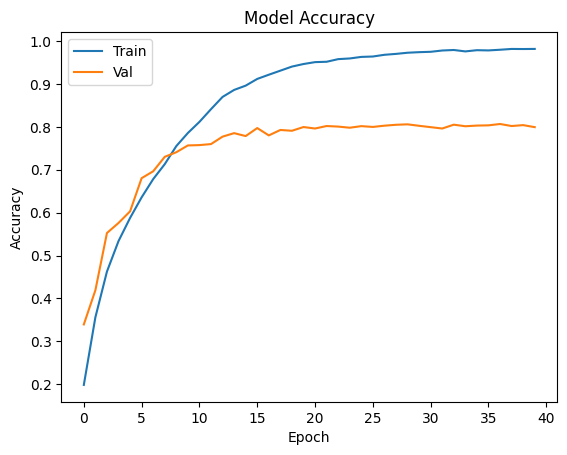

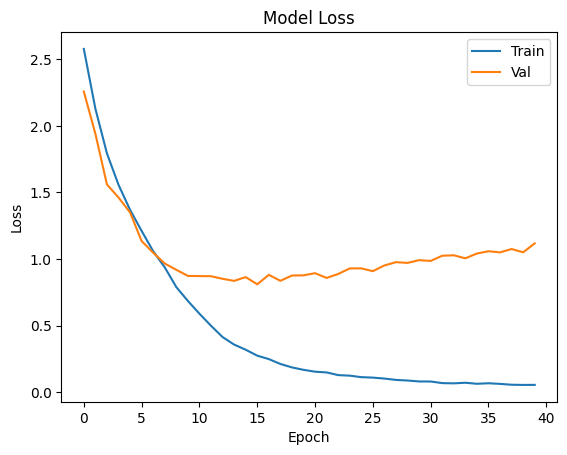

In [ ]:
# Análisis loss/accuracy o pérdida/precisión
plot_acc(m1_hist)
plot_loss(m1_hist)

Como no hemos añadido un EarlyStopping y hemos dejado 40 epochs de entrenamiento, se aprecia overfitting en este modelo.

In [ ]:
# Test
m1_score = m1.evaluate(X_test, y_test, verbose=True)

print("Evaluación del modelo (Datos de test) - Loss : " + str(m1_score[0]))
print("Evaluación del modelo (Datos de test) - Accuracy : " + str(m1_score[1]))
print("Accuracy (Datos de test) en % : " + str(m1_score[1]*100))

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9742 - loss: 0.1744
Evaluación del modelo (Datos de test) - Loss : 0.16682784259319305
Evaluación del modelo (Datos de test) - Accuracy : 0.9730337262153625
Accuracy (Datos de test) en % : 97.30337262153625


Los resultados en test son muy altos y con poco loss, pero no así con los datos de validación.
Como indica el enunciado, puede ser por tener imágenes más "sencillas" en el conjunto de test.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


<Figure size 1000x800 with 0 Axes>

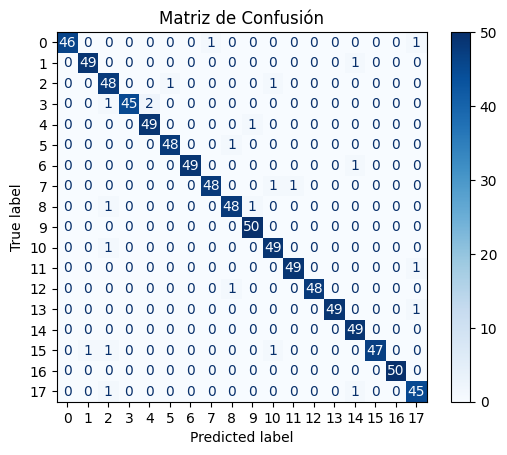

In [ ]:
# Predecir las clases en los datos de prueba
y_pred = np.argmax(m1.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Generar la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(len(np.unique(y_true)))])

# Mostrar la matriz de confusión
plt.figure(figsize=(10, 8))
cm_display.plot(cmap=plt.cm.Blues, values_format='g')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
# Predecir las clases en los datos de prueba
y_pred = np.argmax(m1.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Mostrar un informe detallado de clasificación
report = classification_report(y_true, y_pred, target_names=[f'Clase {i} {MAP_CHARACTERS[i]}' for i in range(len(np.unique(y_true)))])
print("\nInforme de clasificación:\n", report)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Informe de clasificación:
                                   precision    recall  f1-score   support

  Clase 0 abraham_grampa_simpson       1.00      0.96      0.98        48
  Clase 1 apu_nahasapeemapetilon       0.98      0.98      0.98        50
            Clase 2 bart_simpson       0.91      0.96      0.93        50
Clase 3 charles_montgomery_burns       1.00      0.94      0.97        48
            Clase 4 chief_wiggum       0.96      0.98      0.97        50
          Clase 5 comic_book_guy       0.98      0.98      0.98        49
          Clase 6 edna_krabappel       1.00      0.98      0.99        50
           Clase 7 homer_simpson       0.98      0.96      0.97        50
           Clase 8 kent_brockman       0.96      0.96      0.96        50
        Clase 9 krusty_the_clown       0.96      1.00      0.98        50
           Clase 10 lisa_simpson       0.94      0.98      0.96        50
          Clase 11 marge_simpson       0.98 

Se comprueba que los resultados de test dan una accuracy del 97%, superando ese 85% pedido en la actividad.

Sin embargo, parece que hay sobre-ajuste y los resultados en validación podrían mejorarse (las gráficas de accuracy y loss).

Se procede a realizar ajustes en los modelos para lograr un modelo más general.

#### **3.2. M2** Modelo propuesto por un proceso de autoselección de parámetros

Se realiza una selección automática de parámetros para tratar de mejorar el modelo anterior.

Este fragmento de código resulta muy costoso computacionalmente.

Esto nos permite hacer un GridSearch, probar varias combinaciones de parámetros y quedarnos con la que ha dado mejor resultado.

In [ ]:
import scikeras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(learning_rate=0.001, dropout_rate=0.5):
    m_auto = Sequential()
    m_auto.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="mauto_conv2d_1"))
    m_auto.add(Conv2D(64, kernel_size=(3, 3), activation="relu", name="mauto_conv2d_2"))
    m_auto.add(MaxPooling2D(pool_size=(2, 2), name="mauto_maxpool2d_1"))
    m_auto.add(Dropout(0.25, name="mauto_dropout_1"))
    m_auto.add(Flatten(name="mauto_flatten"))
    m_auto.add(Dense(128, activation="relu", name="mauto_dense_1"))
    m_auto.add(Dropout(dropout_rate, name="mauto_dropout_2"))
    m_auto.add(Dense(num_categ, activation="softmax", name="mauto_softmax"))

    optimizer = Adam(learning_rate=learning_rate)
    m_auto.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return m_auto

model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=1,dropout_rate=0.3,learning_rate=0.01)

param_grid = {
    'learning_rate': [0.001, 0.1],
    'dropout_rate': [0.3, 0.5],
    'batch_size': [32, 64],
    'epochs': [10, 30]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

print("Mejores parámetros: %s usando %s" % (grid_result.best_score_, grid_result.best_params_))

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future r

Epoch 1/10
Epoch 1/10
Epoch 1/30
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 1/30


2024-05-30 10:14:41.770005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-30 10:14:41.773689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-30 10:14:41.775698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-30 10:14:41.775785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-30 10:14:41.782314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-30 10:14:41.790261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-30 10:14:41.791100: I tensorflow/core/grappler/optimizers/cust

317/317 ━━━━━━━━━━━━━━━━━━━━ 57s 169ms/step - accuracy: 0.1603 - loss: 2.7897
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 57s 169ms/step - accuracy: 0.1043 - loss: 324.1476
301/317 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.1869 - loss: 2.7216Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 57s 170ms/step - accuracy: 0.1015 - loss: 432.8466
Epoch 2/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 57s 170ms/step - accuracy: 0.1031 - loss: 514.5419
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 58s 172ms/step - accuracy: 0.2334 - loss: 2.5072
Epoch 2/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 58s 172ms/step - accuracy: 0.0978 - loss: 700.0757
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 58s 172ms/step - accuracy: 0.1090 - loss: 191.7810
Epoch 2/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 59s 176ms/step - accuracy: 0.2066 - loss: 2.6290
Epoch 2/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 60s 178ms/step - accuracy: 0.1921 - loss: 2.7018
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.2058 - loss: 2.6619Epoch 2/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 60s 171m

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  7/317 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - accuracy: 0.1152 - loss: 2.7788s: 0.189

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


317/317 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - accuracy: 0.9587 - loss: 0.1330
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.1173 - loss: 2.8088Epoch 11/30
232/317 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - accuracy: 0.9344 - loss: 0.1898Epoch 1/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 53s 166ms/step - accuracy: 0.1173 - loss: 2.8088
 19/317 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.1123 - loss: 2.7985Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 53s 166ms/step - accuracy: 0.1138 - loss: 2.8116
Epoch 11/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/stepp - accuracy: 0.9663 - loss: 0.122
317/317 ━━━━━━━━━━━━━━━━━━━━ 53s 166ms/step - accuracy: 0.9662 - loss: 0.1227
 12/317 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.0589 - loss: 3.27965530.118

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 17/317 ━━━━━━━━━━━━━━━━━━━━ 47s 159ms/step - accuracy: 0.1212 - loss: 2.8209Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/stepep - accuracy: 0.0612 - loss: 7820.698
218/317 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - accuracy: 0.9287 - loss: 0.208418

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 56/317 ━━━━━━━━━━━━━━━━━━━━ 40s 156ms/step - accuracy: 0.9592 - loss: 0.120398Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/stepp - accuracy: 0.9345 - loss: 0.1910257
304/317 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.9345 - loss: 0.1919585

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 61/317 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - accuracy: 0.0783 - loss: 3994.6838Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - accuracy: 0.9346 - loss: 0.1921
Epoch 11/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - accuracy: 0.9429 - loss: 0.164225
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/stepep - accuracy: 0.1084 - loss: 2.895964
121/317 ━━━━━━━━━━━━━━━━━━━━ 31s 160ms/step - accuracy: 0.0927 - loss: 2387.8091

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


307/317 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.9287 - loss: 0.2096Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - accuracy: 0.9287 - loss: 0.209734
Epoch 11/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 52s 165ms/step - accuracy: 0.1108 - loss: 2.817957
Epoch 12/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - accuracy: 0.9622 - loss: 0.11340
297/317 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.1160 - loss: 2.8155Epoch 12/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 55s 165ms/step - accuracy: 0.1048 - loss: 1110.9673
Epoch 2/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 55s 166ms/step - accuracy: 0.1676 - loss: 2.67984
  5/317 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.1034 - loss: 2.7371Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - accuracy: 0.1161 - loss: 2.815319
 37/317 ━━━━━━━━━━━━━━━━━━━━ 47s 168ms/step - accuracy: 0.1028 - loss: 2.8461Epoch 12/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 55s 167ms/step - accuracy: 0.1859 - loss: 2.62530
 37/317 ━━━━━━━━━━━━━━━━━━━━ 45s 163ms/step - accuracy:

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 21/317 ━━━━━━━━━━━━━━━━━━━━ 54s 183ms/step - accuracy: 0.9414 - loss: 0.1357Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 56s 176ms/step - accuracy: 0.9727 - loss: 0.0852
Epoch 21/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.9108 - loss: 0.266922
317/317 ━━━━━━━━━━━━━━━━━━━━ 56s 177ms/step - accuracy: 0.0993 - loss: 2.8143
 60/317 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - accuracy: 0.1270 - loss: 2.8138Epoch 21/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/stepep - accuracy: 0.1500 - loss: 2.760688
137/317 ━━━━━━━━━━━━━━━━━━━━ 32s 179ms/step - accuracy: 0.1091 - loss: 2.822856

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 89/317 ━━━━━━━━━━━━━━━━━━━━ 38s 168ms/step - accuracy: 0.1254 - loss: 2.8132Epoch 1/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 56s 177ms/step - accuracy: 0.7937 - loss: 0.60294
317/317 ━━━━━━━━━━━━━━━━━━━━ 56s 177ms/step - accuracy: 0.1135 - loss: 2.81911
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/stepep - accuracy: 0.0867 - loss: 3.05251
 79/317 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - accuracy: 0.1337 - loss: 2.795594

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 69/159 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/stepEpoch 1/30acy: 0.1246 - loss: 2.81109
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/stepracy: 0.0727 - loss: 3.551ss: 2.80089
153/317 ━━━━━━━━━━━━━━━━━━━━ 29s 180ms/step - accuracy: 0.9541 - loss: 0.12383

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/317 ━━━━━━━━━━━━━━━━━━━━ 33s 171ms/step - accuracy: 0.1277 - loss: 2.8021Epoch 1/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 56s 178ms/step - accuracy: 0.9670 - loss: 0.1072
Epoch 21/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 57s 178ms/step - accuracy: 0.1117 - loss: 2.8168
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/stepep - accuracy: 0.1364 - loss: 2.81208
299/317 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.1232 - loss: 2.810528

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


317/317 ━━━━━━━━━━━━━━━━━━━━ 54s 169ms/step - accuracy: 0.1247 - loss: 2.8073
Epoch 12/30
303/317 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.1231 - loss: 2.8106Epoch 1/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 55s 173ms/step - accuracy: 0.1229 - loss: 2.81077
Epoch 22/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 57s 180ms/step - accuracy: 0.9553 - loss: 0.124492
111/317 ━━━━━━━━━━━━━━━━━━━━ 37s 181ms/step - accuracy: 0.9605 - loss: 0.1119Epoch 21/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 56s 171ms/step - accuracy: 0.1078 - loss: 1350.2506
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 54s 171ms/step - accuracy: 0.9788 - loss: 0.0610
 17/317 ━━━━━━━━━━━━━━━━━━━━ 54s 181ms/step - accuracy: 0.9703 - loss: 0.0848Epoch 22/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.1193 - loss: 2.80831
 62/317 ━━━━━━━━━━━━━━━━━━━━ 43s 170ms/step - accuracy: 0.1290 - loss: 2.8224Epoch 22/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 57s 173ms/step - accuracy: 0.1750 - loss: 2.6934
Epoch 2/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 56s 171ms/step - a

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 24/317 ━━━━━━━━━━━━━━━━━━━━ 51s 175ms/step - accuracy: 0.9814 - loss: 0.0612Epoch 1/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/stepep - accuracy: 0.9658 - loss: 0.101
206/317 ━━━━━━━━━━━━━━━━━━━━ 19s 177ms/step - accuracy: 0.9660 - loss: 0.100560

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


295/317 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.8937 - loss: 0.3095Epoch 1/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 54s 170ms/step - accuracy: 0.9759 - loss: 0.0703
317/317 ━━━━━━━━━━━━━━━━━━━━ 55s 173ms/step - accuracy: 0.1147 - loss: 2.8123600
Epoch 10/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - accuracy: 0.1174 - loss: 2.80998
317/317 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - accuracy: 0.8935 - loss: 0.3101
Epoch 11/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/stepep - accuracy: 0.1141 - loss: 2.810794
 33/317 ━━━━━━━━━━━━━━━━━━━━ 48s 170ms/step - accuracy: 0.1116 - loss: 2.839763

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/stepep - accuracy: 0.9665 - loss: 0.098584
169/317 ━━━━━━━━━━━━━━━━━━━━ 23s 161ms/step - accuracy: 0.1143 - loss: 2.8105Epoch 1/10
 57/317 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.0704 - loss: 2074.7939

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


293/317 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.8969 - loss: 0.2994Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 53s 166ms/step - accuracy: 0.8968 - loss: 0.30007
Epoch 11/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 55s 175ms/step - accuracy: 0.9669 - loss: 0.097292
Epoch 30/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - accuracy: 0.8908 - loss: 0.32559
Epoch 11/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 53s 166ms/step - accuracy: 0.1141 - loss: 2.8105
Epoch 22/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 34s 199ms/step - accuracy: 0.1455 - loss: 2.81155
238/317 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.1121 - loss: 2.8261Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 57s 179ms/step - accuracy: 0.9742 - loss: 0.07960
159/159 ━━━━━━━━━━━━━━━━━━━━ 34s 201ms/step - accuracy: 0.1880 - loss: 2.6865
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 55s 169ms/step - accuracy: 0.0988 - loss: 998.5802
Epoch 2/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/stepp - accuracy: 0.0941 - loss: 588.746
 40/159 ━━━━━━━━━━━━━━━━━━━━ 23s 194ms/step -

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


317/317 ━━━━━━━━━━━━━━━━━━━━ 56s 177ms/step - accuracy: 0.1129 - loss: 2.8235
Epoch 11/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 58s 176ms/step - accuracy: 0.0952 - loss: 552.6960
Epoch 2/30
 74/159 ━━━━━━━━━━━━━━━━━━━━ 16s 195ms/step - accuracy: 0.4276 - loss: 1.8488Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 55s 173ms/step - accuracy: 0.9027 - loss: 0.2898
215/317 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.9703 - loss: 0.0827Epoch 12/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 32s 199ms/step - accuracy: 0.4511 - loss: 1.8025
Epoch 3/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step - accuracy: 0.9107 - loss: 0.2758
 74/159 ━━━━━━━━━━━━━━━━━━━━ 17s 212ms/step - accuracy: 0.1188 - loss: 3.0827Epoch 12/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 61s 192ms/step - accuracy: 0.9701 - loss: 0.0845
159/159 ━━━━━━━━━━━━━━━━━━━━ 32s 201ms/step - accuracy: 0.5052 - loss: 1.6657
118/317 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - accuracy: 0.1141 - loss: 2.8214Epoch 3/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step - accuracy: 0.9070 -

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


131/159 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.1561 - loss: 2.8841Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 56s 178ms/step - accuracy: 0.1155 - loss: 2.81566
  9/159 ━━━━━━━━━━━━━━━━━━━━ 34s 228ms/step - accuracy: 0.0821 - loss: 2583.6130Epoch 23/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 36s 215ms/step - accuracy: 0.1727 - loss: 2.8118
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step - accuracy: 0.1116 - loss: 2.8111
Epoch 3/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step - accuracy: 0.5968 - loss: 1.3075
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step - accuracy: 0.6309 - loss: 1.1923
Epoch 4/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 59s 186ms/step - accuracy: 0.1064 - loss: 2.8180
Epoch 3/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 59s 186ms/step - accuracy: 0.9163 - loss: 0.2502
Epoch 13/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 60s 190ms/step - accuracy: 0.1184 - loss: 2.8164
Epoch 12/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 222ms/step - accuracy: 0.0922 - loss: 396.5862
140/159 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/stepstep - accuracy: 0.1181 - loss: 2.802
 75/159 ━━━━━━━━━━━━━━━━━━━━ 17s 207ms/step - accuracy: 0.1119 - loss: 2.8227

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-30 10:47:38.346035: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-05-30 10:47:38.346086: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-05-30 10:47:38.346096: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-05-30 10:47:38.346126: I tenso

207/317 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.9333 - loss: 0.1912Epoch 1/10
211/317 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - accuracy: 0.9333 - loss: 0.1914

2024-05-30 10:47:39.650233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


317/317 ━━━━━━━━━━━━━━━━━━━━ 59s 185ms/step - accuracy: 0.1096 - loss: 2.8168
Epoch 7/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 58s 184ms/step - accuracy: 0.9369 - loss: 0.1889
Epoch 17/30
  9/317 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9366 - loss: 0.16822522.803

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-30 10:47:41.710342: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-05-30 10:47:41.710369: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-05-30 10:47:41.710376: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-05-30 10:47:41.710399: I tenso

 99/159 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.1127 - loss: 2.8211Epoch 1/10
299/317 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.1137 - loss: 2.8142574

2024-05-30 10:47:43.565335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


317/317 ━━━━━━━━━━━━━━━━━━━━ 59s 187ms/step - accuracy: 0.1137 - loss: 2.81419
226/317 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.9354 - loss: 0.1819Epoch 16/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step - accuracy: 0.9551 - loss: 0.143579
Epoch 10/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step - accuracy: 0.1150 - loss: 2.816363
Epoch 9/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 58s 184ms/step - accuracy: 0.9311 - loss: 0.19521
Epoch 17/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 58s 182ms/step - accuracy: 0.9338 - loss: 0.186631
Epoch 17/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 57s 180ms/step - accuracy: 0.1176 - loss: 2.80747
Epoch 28/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 35s 210ms/step - accuracy: 0.0842 - loss: 1478.9545
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 35s 211ms/step - accuracy: 0.0984 - loss: 826.1631
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 57s 181ms/step - accuracy: 0.1152 - loss: 2.8242
Epoch 8/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 35s 217ms/step - accuracy: 0.9604 - loss: 0.1346
159/159 ━━━━━━━━━━━━━━━━━

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


295/317 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.1132 - loss: 2.8116Epoch 1/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 58s 184ms/step - accuracy: 0.1132 - loss: 2.8116
Epoch 8/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 59s 186ms/step - accuracy: 0.9396 - loss: 0.1821
Epoch 18/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 205ms/step - accuracy: 0.1165 - loss: 2.8075
252/317 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.9374 - loss: 0.1786Epoch 3/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 62s 194ms/step - accuracy: 0.1114 - loss: 2.8218
241/317 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.9336 - loss: 0.1939Epoch 17/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 34s 211ms/step - accuracy: 0.1086 - loss: 2.8067
Epoch 3/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 60s 190ms/step - accuracy: 0.9365 - loss: 0.1803
Epoch 18/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 58s 185ms/step - accuracy: 0.9338 - loss: 0.1927
126/159 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.1039 - loss: 3.0398Epoch 18/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 35s 223ms/step - accuracy: 

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


101/159 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - accuracy: 0.1215 - loss: 2.8074Epoch 1/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 207ms/step - accuracy: 0.1176 - loss: 2.8060
Epoch 4/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 59s 185ms/step - accuracy: 0.1111 - loss: 2.8153
Epoch 9/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 210ms/step - accuracy: 0.1198 - loss: 2.8073
Epoch 4/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 60s 188ms/step - accuracy: 0.1135 - loss: 2.8074
Epoch 9/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 59s 186ms/step - accuracy: 0.9418 - loss: 0.1716
Epoch 19/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 34s 214ms/step - accuracy: 0.3237 - loss: 2.1904
Epoch 3/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 222ms/step - accuracy: 0.1563 - loss: 2.7588
Epoch 2/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 61s 193ms/step - accuracy: 0.1151 - loss: 2.8081
Epoch 18/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step - accuracy: 0.1256 - loss: 2.7995
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step - accuracy: 0.1202 - loss: 2.8036
Epoch 5/10
317/317 ━━━━━━━━━━━━

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 52/159 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/step - accuracy: 0.6779 - loss: 1.0593Epoch 1/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 59s 185ms/step - accuracy: 0.1165 - loss: 2.8128
Epoch 11/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step - accuracy: 0.1153 - loss: 2.8184
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 35s 221ms/step - accuracy: 0.6307 - loss: 1.1706
Epoch 6/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 59s 188ms/step - accuracy: 0.1117 - loss: 2.8133
 73/317 ━━━━━━━━━━━━━━━━━━━━ 46s 190ms/step - accuracy: 0.1194 - loss: 2.8238Epoch 11/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 59s 187ms/step - accuracy: 0.9437 - loss: 0.1580
Epoch 21/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 36s 226ms/step - accuracy: 0.6880 - loss: 1.0217
Epoch 5/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 34s 216ms/step - accuracy: 0.1163 - loss: 2.8063
 22/159 ━━━━━━━━━━━━━━━━━━━━ 29s 215ms/step - accuracy: 0.6976 - loss: 0.9481Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 35s 211ms/step - accuracy: 0.2118 - loss: 2.5476
Epoch 2/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 62s 195ms/step

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


148/159 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.7519 - loss: 0.7436Epoch 1/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 36s 223ms/step - accuracy: 0.7527 - loss: 0.7409
Epoch 9/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 34s 212ms/step - accuracy: 0.1141 - loss: 2.8094
317/317 ━━━━━━━━━━━━━━━━━━━━ 61s 191ms/step - accuracy: 0.1125 - loss: 2.811959
Epoch 13/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/stepstep - accuracy: 0.9428 - loss: 0.163385
159/159 ━━━━━━━━━━━━━━━━━━━━ 36s 226ms/step - accuracy: 0.8646 - loss: 0.411944
Epoch 8/30
 20/317 ━━━━━━━━━━━━━━━━━━━━ 54s 183ms/step - accuracy: 0.1116 - loss: 2.812729

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


126/317 ━━━━━━━━━━━━━━━━━━━━ 36s 192ms/step - accuracy: 0.9512 - loss: 0.1457Epoch 1/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 206ms/step - accuracy: 0.8040 - loss: 0.6566
Epoch 5/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 60s 190ms/step - accuracy: 0.1120 - loss: 2.810117
Epoch 13/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 61s 191ms/step - accuracy: 0.9469 - loss: 0.15316
Epoch 23/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 36s 215ms/step - accuracy: 0.0952 - loss: 493.5486
Epoch 2/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 230ms/step - accuracy: 0.7990 - loss: 0.5952
Epoch 10/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 63s 199ms/step - accuracy: 0.1170 - loss: 2.8113
Epoch 22/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 34s 212ms/step - accuracy: 0.8757 - loss: 0.4069
Epoch 6/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 36s 225ms/step - accuracy: 0.8934 - loss: 0.3205
Epoch 9/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 36s 216ms/step - accuracy: 0.0985 - loss: 1690.5042
214/317 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.1067 - loss: 2.8103Epoch 2/30
317/317 ━━━━━━━━━━━━━━

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 210ms/step - accuracy: 0.9758 - loss: 0.0671
Epoch 20/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step - accuracy: 0.1233 - loss: 2.8069
Epoch 16/30
148/317 ━━━━━━━━━━━━━━━━━━━━ 33s 197ms/step - accuracy: 0.1103 - loss: 2.8253Epoch 1/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 35s 223ms/step - accuracy: 0.9617 - loss: 0.1131
Epoch 22/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 35s 219ms/step - accuracy: 0.1190 - loss: 2.80929
Epoch 16/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 62s 194ms/step - accuracy: 0.9593 - loss: 0.1239
159/159 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - accuracy: 0.9193 - loss: 0.22559
Epoch 24/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 62s 197ms/step - accuracy: 0.9601 - loss: 0.11451
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/stepep - accuracy: 0.1084 - loss: 2.8091
 61/159 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/stepp - accuracy: 0.1140 - loss: 2.820160

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


148/159 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.9796 - loss: 0.0583Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/stepp - accuracy: 0.1142 - loss: 2.820581
187/317 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step - accuracy: 0.1088 - loss: 2.8099

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 34s 217ms/step - accuracy: 0.9795 - loss: 0.0588
Epoch 21/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 34s 215ms/step - accuracy: 0.1175 - loss: 2.8133
Epoch 17/30
201/317 ━━━━━━━━━━━━━━━━━━━━ 22s 196ms/step - accuracy: 0.1091 - loss: 2.8103Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 63s 200ms/step - accuracy: 0.1145 - loss: 2.8201
Epoch 30/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 61s 191ms/step - accuracy: 0.1113 - loss: 2.8132
Epoch 22/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 217ms/step - accuracy: 0.1001 - loss: 876.1166
Epoch 2/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 237ms/step - accuracy: 0.9704 - loss: 0.0896
Epoch 23/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 36s 226ms/step - accuracy: 0.1146 - loss: 2.8136
Epoch 17/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 63s 199ms/step - accuracy: 0.1101 - loss: 2.8121
114/317 ━━━━━━━━━━━━━━━━━━━━ 42s 209ms/step - accuracy: 0.1193 - loss: 2.8108Epoch 22/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 235ms/step - accuracy: 0.9197 - loss: 0.2251
126/159 ━━━━━━━━━━━━━━━━━━━━ 7s 231m

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 36s 228ms/step - accuracy: 0.1155 - loss: 2.8050
Epoch 4/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 232ms/step - accuracy: 0.3701 - loss: 2.0721
Epoch 3/10
 46/159 ━━━━━━━━━━━━━━━━━━━━ 26s 236ms/step - accuracy: 0.9227 - loss: 0.2182Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 243ms/step - accuracy: 0.9678 - loss: 0.0921
 95/317 ━━━━━━━━━━━━━━━━━━━━ 44s 202ms/step - accuracy: 0.1003 - loss: 2.8075Epoch 25/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 232ms/step - accuracy: 0.1175 - loss: 2.8035
Epoch 19/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 66s 208ms/step - accuracy: 0.1088 - loss: 2.8093
Epoch 23/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 249ms/step - accuracy: 0.9231 - loss: 0.2184
 65/159 ━━━━━━━━━━━━━━━━━━━━ 22s 244ms/step - accuracy: 0.1185 - loss: 2.8070Epoch 27/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 232ms/step - accuracy: 0.9768 - loss: 0.0650
Epoch 24/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 231ms/step - accuracy: 0.1174 - loss: 2.8078
Epoch 20/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 233ms/s

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


224/317 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 0.1213 - loss: 2.8090Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 246ms/step - accuracy: 0.5866 - loss: 1.2644
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 238ms/step - accuracy: 0.1167 - loss: 2.80448
Epoch 24/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 40s 254ms/step - accuracy: 0.9767 - loss: 0.074118
111/159 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step - accuracy: 0.1198 - loss: 2.8098Epoch 30/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 67s 212ms/step - accuracy: 0.1192 - loss: 2.8097
Epoch 26/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 233ms/step - accuracy: 0.9871 - loss: 0.0403
Epoch 29/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 232ms/step - accuracy: 0.1203 - loss: 2.80129
Epoch 25/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 236ms/step - accuracy: 0.7628 - loss: 0.706625
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 238ms/step - accuracy: 0.1194 - loss: 2.8085
172/317 ━━━━━━━━━━━━━━━━━━━━ 30s 208ms/step - accuracy: 0.1193 - loss: 2.8122Epoch 10/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 2

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.1076 - loss: 2.8071Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 238ms/step - accuracy: 0.1077 - loss: 2.8071
Epoch 11/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 238ms/step - accuracy: 0.8647 - loss: 0.398728
Epoch 10/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 246ms/step - accuracy: 0.6959 - loss: 0.9108
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 40s 252ms/step - accuracy: 0.1192 - loss: 2.8059
 66/159 ━━━━━━━━━━━━━━━━━━━━ 22s 244ms/step - accuracy: 0.1193 - loss: 2.7978Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 239ms/step - accuracy: 0.1161 - loss: 2.8103
Epoch 26/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 67s 213ms/step - accuracy: 0.1071 - loss: 2.8055
Epoch 27/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 0.9865 - loss: 0.0388
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/steptep - accuracy: 0.1176 - loss: 2.8124
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 235ms/step - accuracy: 0.1176 - loss: 2.8128
Epoch 27/30
197/317 ━━━━━━━━━━━━━━━━━━━━ 24s 206ms/step - accur

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 0.8114 - loss: 0.5424
 89/159 ━━━━━━━━━━━━━━━━━━━━ 16s 240ms/step - accuracy: 0.7172 - loss: 0.8209Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 236ms/step - accuracy: 0.1164 - loss: 2.8019
Epoch 12/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/steptep - accuracy: 0.8848 - loss: 0.356
139/159 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.8846 - loss: 0.35696

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


231/317 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - accuracy: 0.1099 - loss: 2.8173Epoch 1/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 41s 247ms/step - accuracy: 0.1078 - loss: 398.9099
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 0.8839 - loss: 0.35795
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/stepstep - accuracy: 0.1235 - loss: 2.793
 46/159 ━━━━━━━━━━━━━━━━━━━━ 26s 237ms/step - accuracy: 0.1145 - loss: 2.8081

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 52/159 ━━━━━━━━━━━━━━━━━━━━ 24s 231ms/step - accuracy: 0.0876 - loss: 744.3531Epoch 1/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 241ms/step - accuracy: 0.7198 - loss: 0.8172
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 240ms/step - accuracy: 0.1148 - loss: 2.80477
 53/159 ━━━━━━━━━━━━━━━━━━━━ 26s 252ms/step - accuracy: 0.1203 - loss: 2.8032Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 236ms/step - accuracy: 0.1165 - loss: 2.8098
Epoch 27/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 65s 206ms/step - accuracy: 0.1110 - loss: 2.8162
Epoch 28/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 233ms/step - accuracy: 0.1140 - loss: 2.8109
Epoch 28/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 234ms/step - accuracy: 0.1014 - loss: 323.0523
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 236ms/step - accuracy: 0.1139 - loss: 2.8077
 89/159 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - accuracy: 0.7505 - loss: 0.7169Epoch 13/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 237ms/step - accuracy: 0.1307 - loss: 2.8648
Epoch 2/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 41s 256m

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


135/159 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.1210 - loss: 2.8122Epoch 1/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 0.1202 - loss: 2.8119
 69/159 ━━━━━━━━━━━━━━━━━━━━ 21s 241ms/step - accuracy: 0.3276 - loss: 2.1053Epoch 30/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 236ms/step - accuracy: 0.1176 - loss: 2.8053
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 239ms/step - accuracy: 0.1090 - loss: 2.8165
Epoch 15/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 237ms/step - accuracy: 0.5124 - loss: 1.6064
Epoch 4/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 68s 215ms/step - accuracy: 0.1155 - loss: 2.8105
Epoch 29/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 40s 251ms/step - accuracy: 0.1139 - loss: 2.8055
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 241ms/step - accuracy: 0.3390 - loss: 2.0775
Epoch 4/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 242ms/step - accuracy: 0.1182 - loss: 2.8045
Epoch 30/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 245ms/step - accuracy: 0.1177 - loss: 2.8085
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 40

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 0.1168 - loss: 2.8039
Epoch 16/30
 80/159 ━━━━━━━━━━━━━━━━━━━━ 18s 238ms/step - accuracy: 0.1143 - loss: 2.8063Epoch 1/30
317/317 ━━━━━━━━━━━━━━━━━━━━ 67s 210ms/step - accuracy: 0.1108 - loss: 2.8129
Epoch 30/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 232ms/step - accuracy: 0.6116 - loss: 1.2784
Epoch 5/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 40s 249ms/step - accuracy: 0.1205 - loss: 2.80743
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 239ms/step - accuracy: 0.4090 - loss: 1.837206
Epoch 5/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 240ms/step - accuracy: 0.1162 - loss: 2.807334
159/159 ━━━━━━━━━━━━━━━━━━━━ 40s 251ms/step - accuracy: 0.1186 - loss: 2.811313
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/stepstep - accuracy: 0.1017 - loss: 2.81673
  8/159 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.1291 - loss: 2.814825

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


288/317 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.1098 - loss: 2.8170Epoch 1/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 241ms/step - accuracy: 0.3694 - loss: 2.07114
Epoch 3/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 230ms/step - accuracy: 0.1188 - loss: 2.80596
Epoch 6/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 67s 212ms/step - accuracy: 0.1101 - loss: 2.81643
Epoch 30/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 237ms/step - accuracy: 0.1159 - loss: 2.80506
Epoch 17/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 236ms/step - accuracy: 0.0905 - loss: 964.8183
Epoch 2/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 236ms/step - accuracy: 0.6757 - loss: 1.0367
Epoch 6/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 236ms/step - accuracy: 0.4812 - loss: 1.599322
Epoch 6/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 41s 256ms/step - accuracy: 0.1164 - loss: 2.8078
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 247ms/step - accuracy: 0.1190 - loss: 2.8131
139/159 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - accuracy: 0.4804 - loss: 1.6855Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 235ms/step - accuracy: 0.1130 - loss: 2.8122
Epoch 3/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 240ms/step - accuracy: 0.7385 - loss: 0.8164
Epoch 7/30
109/159 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.5145 - loss: 1.4720Epoch 1/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 39s 245ms/step - accuracy: 0.5162 - loss: 1.46221
Epoch 7/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 40s 252ms/step - accuracy: 0.1152 - loss: 2.8113
Epoch 8/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 68s 213ms/step - accuracy: 0.1119 - loss: 2.80901
159/159 ━━━━━━━━━━━━━━━━━━━━ 40s 251ms/step - accuracy: 0.1156 - loss: 2.8062
Epoch 10/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 40s 249ms/step - accuracy: 0.5657 - loss: 1.3869
Epoch 5/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 242ms/step - accuracy: 0.1048 - loss: 2.80839
Epoch 3/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/stepp - accuracy: 0.1161 - loss: 2.81394
159/159 ━━━━━━━━━━━━━━━━━━━━ 37s 235ms/step - accuracy: 0.1159 - loss: 2.8042
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 38s 240ms/s

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.1639 - loss: 2.7077
Epoch 2/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.4172 - loss: 1.9036
Epoch 3/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.5068 - loss: 1.5591
Epoch 4/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.5838 - loss: 1.2925
Epoch 5/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.6484 - loss: 1.0549
Epoch 6/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.6987 - loss: 0.8931
Epoch 7/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.7313 - loss: 0.7956
Epoch 8/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7533 - loss: 0.6863
Epoch 9/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.7807 - loss: 0.6231
Epoch 10/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.7996 - loss: 0.5594
Epoch 11/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8187 - loss: 0.5138
Epoch 12/30
475/475 ━━━━━━━━━━

Se han probado:
* learning_rate: [0.001, 0.1]
* dropout_rate: [0.3, 0.5],
* batch_size: [32, 64],
* epochs: [10, 30]

Se tiene:

Mejores parámetros: 0.729744105979819 usando {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 30, 'learning_rate': 0.001}

Luego parece que, en general, nos va mejor un learning_rate bajo (0.01), un dropout_rate alto (0.05), un batch_size de 32 y un número de epochs alto.


Usaremos estos parámetros a continuación, aunque el accuracy conseguido no es muy alto.

**M2:** Se prueban los mejores parámetros dados en el auto entrenamiento:

| Nombre modelo | Cant. capas | Func. act. | Optimizador | Caracts. extra |
| ------------- | ----------- | ---------- | ----------- | -------------- |
|       M2      |      2 Conv (MaxPooling) + 2 Dense       |     Relu       |     Adam        |       MaxPooling         |

In [ ]:
m2 = Sequential()
m2.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="m2_conv2d_1"))
m2.add(Conv2D(64, kernel_size=(3, 3), activation="relu", name="m2_conv2d_2"))
m2.add(MaxPooling2D(pool_size=(2, 2), name="m2_maxpool2d_1"))
m2.add(Dropout(0.25, name="m2_dropout_1"))
m2.add(Flatten(name="m2_flatten"))
m2.add(Dense(128, activation="relu", name="m2_dense_1"))
m2.add(Dropout(0.5, name="m2_dropout_2"))
m2.add(Dense(num_categ, activation="softmax", name="m2_softmax"))

optimizer = Adam(learning_rate=0.001)
m2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-30 17:24:46.310251: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-30 17:24:46.310270: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
m2_batch_size = 32
m2_epochs = 30

m2_hist = m2.fit(X_train, y_train, batch_size=m2_batch_size,
                epochs=m2_epochs,
                verbose=True,
                validation_data=(X_val, y_val)
)

Epoch 1/30


2024-05-30 17:24:48.331669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


475/475 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.1919 - loss: 2.6315 - val_accuracy: 0.5193 - val_loss: 1.6400
Epoch 2/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.4846 - loss: 1.6880 - val_accuracy: 0.6346 - val_loss: 1.3284
Epoch 3/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.6111 - loss: 1.2578 - val_accuracy: 0.6860 - val_loss: 1.1019
Epoch 4/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6977 - loss: 0.9735 - val_accuracy: 0.7086 - val_loss: 1.0080
Epoch 5/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7509 - loss: 0.7854 - val_accuracy: 0.7270 - val_loss: 0.9657
Epoch 6/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.7985 - loss: 0.6230 - val_accuracy: 0.7423 - val_loss: 0.9527
Epoch 7/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8324 - loss: 0.5127 - val_accuracy: 0.7441 - val_loss: 0.9671
Epoch 8/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8532 - loss: 0.4364 - val_accurac

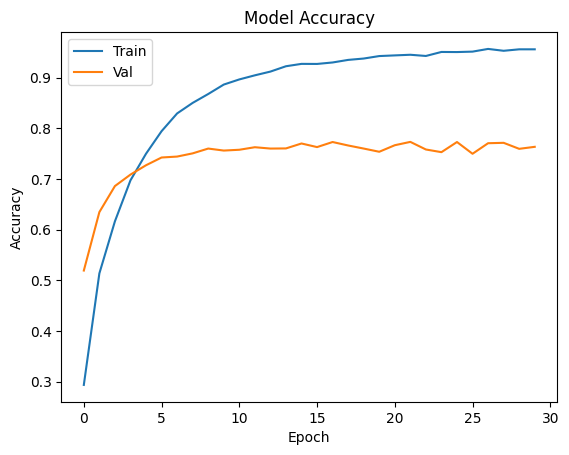

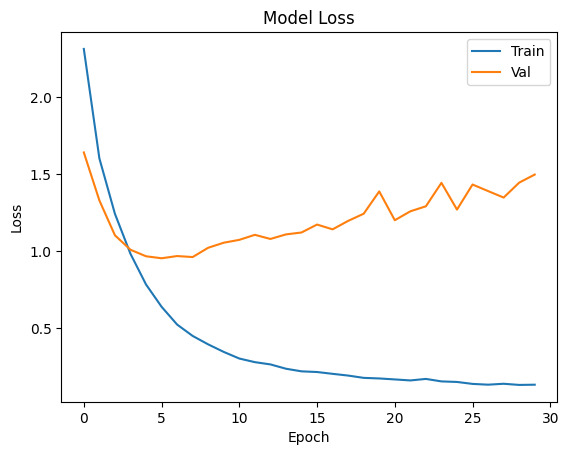

In [ ]:
# Análisis loss/accuracy o pérdida/precisión
plot_acc(m2_hist)
plot_loss(m2_hist)

In [ ]:
# Test
m2_score = m2.evaluate(X_test, y_test, verbose=True)

print("Evaluación del modelo (Datos de test) - Loss : " + str(m2_score[0]))
print("Evaluación del modelo (Datos de test) - Accuracy : " + str(m2_score[1]))
print("Accuracy (Datos de test) en % : " + str(m2_score[1]*100))

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9649 - loss: 0.1969
Evaluación del modelo (Datos de test) - Loss : 0.20480012893676758
Evaluación del modelo (Datos de test) - Accuracy : 0.9674157500267029
Accuracy (Datos de test) en % : 96.74157500267029


El modelo continúa dando muy buenos resultados con los datos de Test, pero sigue con una curva de loss muy marcada.

Es importante tener en cuenta que, aunque se estén tomando los valores de los parámetros que mejores resultados dan en la GridSearch, es posible que los mejores parámetros no se hayan incluido en la búsqueda, y por tanto, existan combinaciones de hiperparámetros que mejoren el resultado actual.

Además, la búsqueda de hiperparámetros se ha realizado sobre una arquitectura de red determinada. Por tanto, también podríamos encontrar mejoras cambiando la arquitectra de la red. En resumen, la búsqueda de hiperparámetros nos ha servido de guía pero podemos encontrar redes que se ajusten mejor a nuestro problema.

A continuación haremos cambios más sustanciales en la topología de capas.

#### **3.3. M3** Se cambia la arquitectura y el número de capas del modelo anterior en un intento de mejora:

| Nombre modelo | Cant. capas | Func. act. | Optimizador | Caracts. extra |
| ------------- | ----------- | ---------- | ----------- | -------------- |
|       M3      |    3  Conv (AvgPooling) + 3 Dense      |   Relu         |   Adam          |         AveragePooling / EarlyStopping          |

In [ ]:
# Cambiamos el Pooling de Max a Average
m3 = Sequential()
m3.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="m3_conv2d_1"))
m3.add(AveragePooling2D(pool_size=(2, 2), name="m3_maxpool2d_1"))
m3.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", name="m3_conv2d_2"))
m3.add(AveragePooling2D(pool_size=(2, 2), name="m3_maxpool2d_2"))
m3.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", name="m3_conv2d_3"))
m3.add(AveragePooling2D(pool_size=(2, 2), name="m3_maxpool2d_3"))
m3.add(Flatten(name="m3_flatten"))
m3.add(Dense(units=128, activation="relu", name="m3_dense_1"))
m3.add(Dropout(0.3, name="m3_dropout_1"))
m3.add(Dense(units=64, activation="relu", name="m3_dense_2"))
m3.add(Dense(num_categ, activation="softmax", name="m3_softmax"))

m3.summary()

# Optimizador:ADAM
m3_opt = Adam(learning_rate=0.001)

m3.compile(
    loss="categorical_crossentropy",
    optimizer=m3_opt,
    metrics=["accuracy"]
)


/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ m3_conv2d_1 (Conv2D)            │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_maxpool2d_1                  │ (None, 29, 29, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_conv2d_2 (Conv2D)            │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_maxpool2d_2                  │ (None, 13, 13, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_conv2d_3 (Conv2D)            │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_maxpool2d_3                  │ (None, 5, 5, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_flatten (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_dense_1 (Dense)              │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_dropout_1 (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_dense_2 (Dense)              │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m3_softmax (Dense)              │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 512,402 (1.95 MB)

 Trainable params: 512,402 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


#EarlyStopping monitorizando el loss en validación, pues buscamos mejorar la generalización
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# Entrenamiento M3
m3_batch_size = 32
m3_epochs = 50 # Aumentamos el número de epochs al añadir el EarlyStopping

m3_hist = m3.fit(X_train, y_train, batch_size=m3_batch_size,
                epochs=m3_epochs,
                verbose=True,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping]
)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.1748 - loss: 2.6119 - val_accuracy: 0.4543 - val_loss: 1.7871
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.4464 - loss: 1.8244 - val_accuracy: 0.5815 - val_loss: 1.3801
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5611 - loss: 1.4130 - val_accuracy: 0.6596 - val_loss: 1.1284
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6408 - loss: 1.1634 - val_accuracy: 0.6941 - val_loss: 0.9844
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.7002 - loss: 0.9571 - val_accuracy: 0.7307 - val_loss: 0.9079
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7480 - loss: 0.8024 - val_accuracy: 0.7491 - val_loss: 0.8263
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7834 - loss: 0.6695 - val_accuracy: 0.7591 - val_loss: 0.8017
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8084 - loss: 0.6018 - v

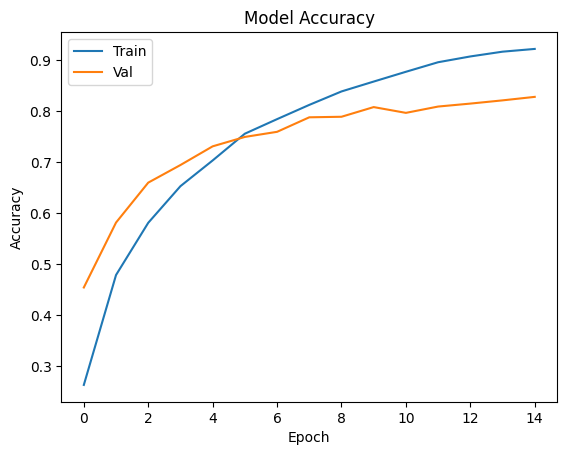

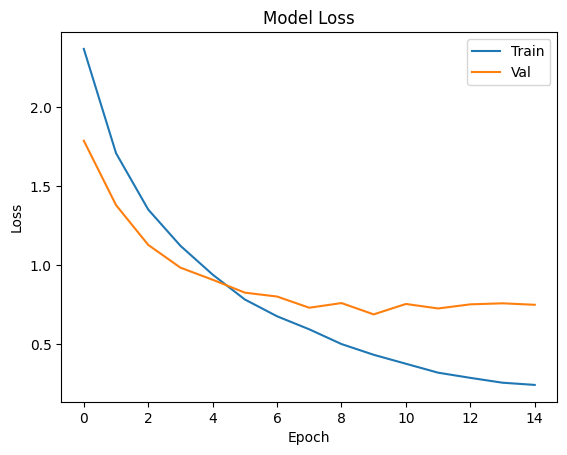

In [ ]:
# Análisis loss/accuracy o pérdida/precisión
plot_acc(m3_hist)
plot_loss(m3_hist)

In [ ]:
# Test
m3_score = m3.evaluate(X_test, y_test, verbose=True)

print("Evaluación del modelo (Datos de test) - Loss : " + str(m3_score[0]))
print("Evaluación del modelo (Datos de test) - Accuracy : " + str(m3_score[1]))
print("Accuracy (Datos de test) en % : " + str(m3_score[1]*100))

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9278 - loss: 0.2978
Evaluación del modelo (Datos de test) - Loss : 0.2433510273694992
Evaluación del modelo (Datos de test) - Accuracy : 0.9370786547660828
Accuracy (Datos de test) en % : 93.70786547660828


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


<Figure size 1000x800 with 0 Axes>

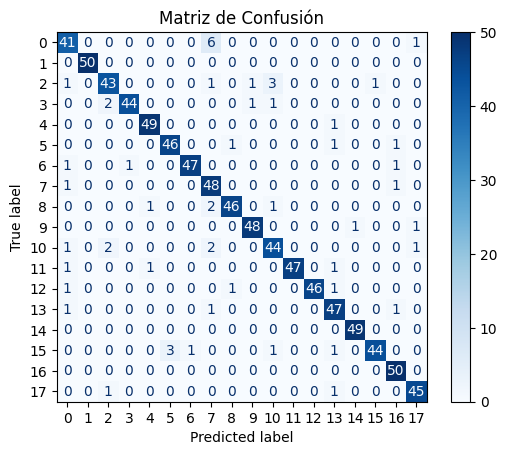

In [ ]:
# Predecir las clases en los datos de prueba
y_pred_m3 = np.argmax(m3.predict(X_test), axis=1)
y_true_m3 = np.argmax(y_test, axis=1)

# Generar la matriz de confusión
cm_m3 = confusion_matrix(y_true_m3, y_pred_m3)
cm_display_m3 = ConfusionMatrixDisplay(confusion_matrix=cm_m3, display_labels=[i for i in range(len(np.unique(y_true_m3)))])

# Mostrar la matriz de confusión
plt.figure(figsize=(10, 8))
cm_display_m3.plot(cmap=plt.cm.Blues, values_format='g')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
# Mostrar un informe detallado de clasificación
report_m3 = classification_report(y_true_m3, y_pred_m3, target_names=[f'Clase {i} {MAP_CHARACTERS[i]}' for i in range(len(np.unique(y_true_m3)))])
print("\nInforme de clasificación:\n", report_m3)


Informe de clasificación:
                                   precision    recall  f1-score   support

  Clase 0 abraham_grampa_simpson       0.85      0.85      0.85        48
  Clase 1 apu_nahasapeemapetilon       1.00      1.00      1.00        50
            Clase 2 bart_simpson       0.90      0.86      0.88        50
Clase 3 charles_montgomery_burns       0.98      0.92      0.95        48
            Clase 4 chief_wiggum       0.96      0.98      0.97        50
          Clase 5 comic_book_guy       0.94      0.94      0.94        49
          Clase 6 edna_krabappel       0.98      0.94      0.96        50
           Clase 7 homer_simpson       0.80      0.96      0.87        50
           Clase 8 kent_brockman       0.96      0.92      0.94        50
        Clase 9 krusty_the_clown       0.96      0.96      0.96        50
           Clase 10 lisa_simpson       0.88      0.88      0.88        50
          Clase 11 marge_simpson       1.00      0.94      0.97        50
    Clase

El modelo 3 con early stopping y el cambio de arquitectura y parámetros sigue mostrando un buen rendimiento de 93% de accuracy en datos de test y se ha conseguido bajar el loss en validación, aunque sigue siendo alto. El early stopping parece que ha favorecido a reducir el sobreajuste.

Se puede observar que presenta algunos problemas con las imágenes de Homer y su padre (Abraham Simpson).


#### **3.4. M4** Se añade Data Augmentation y capas de BatchNormalization:

| Nombre modelo | Cant. capas | Func. act. | Optimizador | Caracts. extra                                                                   |
| ------------- | ----------- | ---------- | ----------- |----------------------------------------------------------------------------------|
|       M4      |      3 Conv + 3 Dense + 4 BatchNorm      |    Relu        |       Adam      | Data Augmentation + BatchNormalization + EarlyStopping + GlobalAveragePooling + ReduceLROnPlateau |

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D

m4 = Sequential()
m4.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape, name="m4_conv2d_1"))
m4.add(BatchNormalization(name="m4_batchnorm_1"))
m4.add(MaxPooling2D(pool_size=(2, 2), name="m4_maxpool2d_1"))

m4.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", name="m4_conv2d_2"))
m4.add(BatchNormalization(name="m4_batchnorm_2"))
m4.add(MaxPooling2D(pool_size=(2, 2), name="m4_maxpool2d_2"))

m4.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", name="m4_conv2d_3"))
m4.add(BatchNormalization(name="m4_batchnorm_3"))
m4.add(MaxPooling2D(pool_size=(2, 2), name="m4_maxpool2d_3"))

# m4.add(Flatten(name="m4_flatten"))
# Global Average Pooling en lugar de Flatten
m4.add(GlobalAveragePooling2D(name="m4_globalavgpool"))

m4.add(Dense(units=128, activation="relu", name="m4_dense_1")) #, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
m4.add(Dropout(0.4, name="m4_dropout_1"))
m4.add(Dense(units=64, activation="relu", name="m4_dense_2")) #, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
#añadimos otro dropout antes del softmax
m4.add(Dropout(0.4, name="m4_dropout_2"))
m4.add(Dense(num_categ, activation="softmax", name="m4_softmax"))

m4_opt = Adam(learning_rate=0.001)
m4.compile(
    loss="categorical_crossentropy",
    optimizer=m4_opt,
    metrics=["accuracy"]
)
early_stopping_m4 = EarlyStopping(monitor='val_loss', patience=8)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001)

/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Añadimos un generador de datos (Data Augmentation).

Se han probado varios rangos de parámetros, optando finalmente por la siguiente configuración.

Buscamos con esto tener más datos para el entrenamiento y conseguir un modelo más robusto.

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

Mantenemos 50 epochs con EarlyStopping.

In [ ]:
m4_batch_size = 32
m4_epochs = 50
m4_hist = m4.fit(datagen.flow(X_train, y_train, batch_size=m4_batch_size),
                epochs=m4_epochs,
                verbose=True,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping_m4,reduce_lr]
)

Epoch 1/50


/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


475/475 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.1405 - loss: 2.7770 - val_accuracy: 0.2693 - val_loss: 2.3577 - learning_rate: 0.0010
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.3402 - loss: 2.1591 - val_accuracy: 0.5794 - val_loss: 1.4247 - learning_rate: 0.0010
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.5284 - loss: 1.5708 - val_accuracy: 0.6383 - val_loss: 1.1596 - learning_rate: 0.0010
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.6419 - loss: 1.2124 - val_accuracy: 0.6894 - val_loss: 1.0040 - learning_rate: 0.0010
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.6947 - loss: 1.0351 - val_accuracy: 0.7041 - val_loss: 1.0358 - learning_rate: 0.0010
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.7333 - loss: 0.9100 - val_accuracy: 0.7228 - val_loss: 0.9793 - learning_rate: 0.0010
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.7537 - loss: 0.8504

En este caso se detecta que el EarlyStopping no ha saltado, llegando al máximo de Epochs.

Creemos que se debe al uso de BatchNormalization.

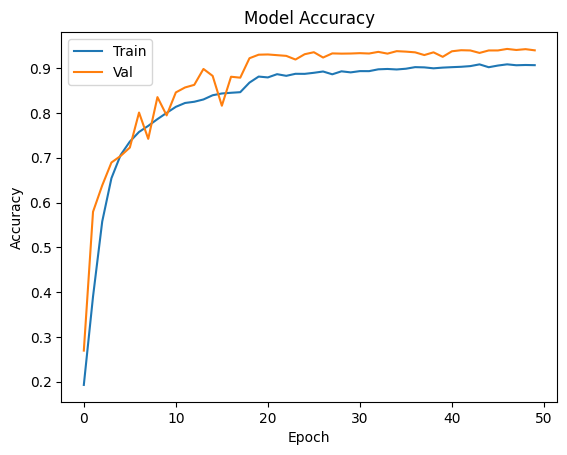

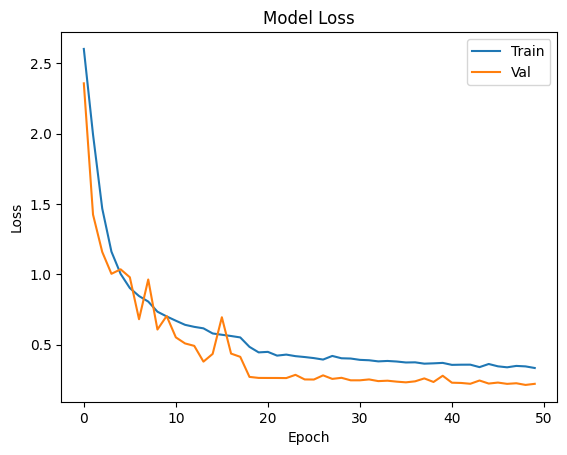

In [ ]:
plot_acc(m4_hist)
plot_loss(m4_hist)

In [ ]:
m4_score = m4.evaluate(X_test, y_test, verbose=True)

print("Evaluación del modelo (Datos de test) - Loss : " + str(m4_score[0]))
print("Evaluación del modelo (Datos de test) - Accuracy : " + str(m4_score[1]))
print("Accuracy (Datos de test) en % : " + str(m4_score[1]*100))

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9509 - loss: 0.1688
Evaluación del modelo (Datos de test) - Loss : 0.1365004926919937
Evaluación del modelo (Datos de test) - Accuracy : 0.9640449285507202
Accuracy (Datos de test) en % : 96.40449285507202


Conseguimos un buen accuracy y loss en datos de test. Parece que logramos controlar el sobre-ajuste.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


<Figure size 1000x800 with 0 Axes>

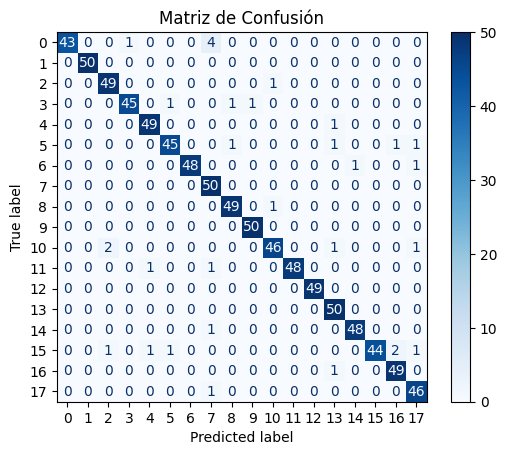

In [ ]:
# Predecir las clases en los datos de prueba
y_pred_m4 = np.argmax(m4.predict(X_test), axis=1)
y_true_m4 = np.argmax(y_test, axis=1)

# Generar la matriz de confusión
cm_m4 = confusion_matrix(y_true_m4, y_pred_m4)
cm_display_m4 = ConfusionMatrixDisplay(confusion_matrix=cm_m4, display_labels=[i for i in range(len(np.unique(y_true_m4)))])

# Mostrar la matriz de confusión
plt.figure(figsize=(10, 8))
cm_display_m4.plot(cmap=plt.cm.Blues, values_format='g')
plt.title('Matriz de Confusión')
plt.show()


In [ ]:
report = classification_report(y_true_m4, y_pred_m4, target_names=[f'Clase {i} {MAP_CHARACTERS[i]}' for i in range(len(np.unique(y_true_m4)))])
print("\nInforme de clasificación:\n", report)


Informe de clasificación:
                                   precision    recall  f1-score   support

  Clase 0 abraham_grampa_simpson       1.00      0.90      0.95        48
  Clase 1 apu_nahasapeemapetilon       1.00      1.00      1.00        50
            Clase 2 bart_simpson       0.94      0.98      0.96        50
Clase 3 charles_montgomery_burns       0.98      0.94      0.96        48
            Clase 4 chief_wiggum       0.96      0.98      0.97        50
          Clase 5 comic_book_guy       0.96      0.92      0.94        49
          Clase 6 edna_krabappel       1.00      0.96      0.98        50
           Clase 7 homer_simpson       0.88      1.00      0.93        50
           Clase 8 kent_brockman       0.96      0.98      0.97        50
        Clase 9 krusty_the_clown       0.98      1.00      0.99        50
           Clase 10 lisa_simpson       0.96      0.92      0.94        50
          Clase 11 marge_simpson       1.00      0.96      0.98        50
    Clase

Aunque continuamos teniendo problemas con la clasificación de algunos personajes, hemos conseguido obtener un modelo más robusto y con una accuracy superior al 85% en test requerido.

Como en el modelo anterior el mayor problema lo tenemos con los personajes 0 (el abuelo) y 7 (Homer).

Sin embargo, hemos mejorado el f1-score también con estos personajes.

## **Conclusiones**

Hemos empezado realizando tareas para conocer el propio dataset.En el análisis exploratorio, hemos adaptado los datos para el tipo de problema al que nos íbamos a afrontar empleando redes neuronales convolucionales.

Antes de comenzar a trabajar con las propias CNN, empezamos a usar Google Colab. Sin embargo, nos enfrentamos a momentos en los que las GPUs dejaban de estar libres para la versión gratuita. Por ello, comenzamos a pensar en configurar un entorno local para usar nuestras GPUs (en nuestro caso, no teníamos la suerte de emplear TPUs). Afortunadamente, lo terminamos consiguiendo.

Una vez hecho, pudimos experimentar con los límites que nuestro hardware nos imponía.

El primer modelo fully connected nos sirvió para darnos cuenta de la necesidad de ir un paso más allá, ya que no conseguíamos un ratio de accuracy mínimamente aceptable.

Empezamos añadiendo capas convolucionales en el modelo M1. Introducimos 2 capas convolucionales, max pooling y dropout; con optimizador adagrad. Pese a conseguir buenos resultados de accuracy en train y en test, validation nos hizo pensar en que teníamos un sobre-ajuste elevado.

Por ello, en el M2 probamos un modo que nos servía para seleccionar distintos valores de los hiperparámetros. Con los valores de los hiperparámetros anteriores entrenamos un nuevo modelo, pero tampoco fueron demasiado esperanzadores los nuevos resultados.

En el M3, añadimos una nueva capa convolucional y cambiamos el max pooling por average pooling. Recordar que no hemos variado la función de activación de todas las capas desde un principio. Ahora, conseguimos mejorar el rendimiento, pero los resultados de validation nos hacen indicar que el sobre-ajuste seguía ahí.

El siguiente modelo, el M4, añadimos Daa Augmentation, introducimos Batch Normalization, mantenemos el early stopping y cambiamos a global average pooling. Además, pasamos a 3 capas convolucionales y otras 3 densas. También seguimos manteniendo el dropout del mismo modo. También introducimos el callback ReduceLROnPlateau, que nos sirve para reducir aún más el learning rate cuando llegamos a la meseta. Por fin, esta vez sí, parece que logramos controlar el overfitting.

Comparando con el primer modelo, los resultados en test del M1 parecen ser ligeramente mejores que los del último modelo. Sin embargo, nos parece más fiable tomar este último modelo debido al sobreajuste que parece haber en el M1.

A lo largo de todo el ejercicio hemos visto que hay varios personajes a los cuales les ha costado distinguir, como entre homer y el abuelo. Pese a ello, creemos que los resultados obtenidos son adecuados, habiendo conseguido incrementar los resultados de las métricas en el último modelo.